# Setup

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
import plotly.io as pio

from statsmodels.stats import multitest
import networkx as nx

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"
reports_comunidades = "../../../reports/reports_nohubs/analisis_comunidades/"
reports_genes = "../../../reports/reports_nohubs/analisis_red_genes/"

In [62]:
graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
infomap_results = pd.read_csv(reports_genes+"infomap_genesim_pvalues.csv").drop(columns="Unnamed: 0").rename(columns={"comunidades_infomap":"comunidad"})
louvain_results = pd.read_csv(reports_genes+"louvain_genesim_pvalues.csv").drop(columns="Unnamed: 0").rename(columns={"comunidades_louvain":"comunidad"})

infomap_degree = pd.read_csv(reports_comunidades+"grado_gda_infomap.csv")
louvain_degree = pd.read_csv(reports_comunidades+"grado_gda_louvain.csv")

infomap_all_metrics = pd.read_csv(reports_genes+"infomap_gene_sim.csv")
louvain_all_metrics = pd.read_csv(reports_genes+"louvain_gene_sim.csv")

In [63]:
infomap_data = infomap_degree.merge(infomap_results, right_on="comunidad",left_on="comunidad").dropna()
infomap_data

,comunidad,tamaño,fraccion_gda,grado_gda_medio,max_grado_gda,mean_sim_overlap_3,pvalue_overlap_3
0,382,82,0.79,1.74,12.0,0.07,0.000
1,184,74,0.99,1.75,24.0,0.12,0.000
2,332,74,0.93,2.54,104.0,0.35,0.000
3,353,71,0.75,3.26,37.0,0.34,0.000
4,379,68,0.97,1.21,14.0,0.03,0.007
...,...,...,...,...,...,...,...
1138,1000,2,1.00,4.00,4.0,1.00,0.000
1139,1131,2,1.00,4.00,4.0,1.00,0.000
1141,1136,2,1.00,2.50,4.0,1.00,0.000
1144,891,2,1.00,3.00,4.0,0.15,0.219


In [64]:
louvain_data = louvain_degree.merge(louvain_results, right_on="comunidad",left_on="comunidad").dropna()
louvain_data

,comunidad,tamaño,fraccion_gda,grado_gda_medio,max_grado_gda,mean_sim_overlap_3,pvalue_overlap_3
0,3,702,0.33,41.15,1074.0,0.47,0.000
1,18,369,0.62,4.12,75.0,0.08,0.002
2,16,333,0.37,7.38,110.0,0.25,0.000
3,33,304,0.23,3.58,52.0,0.21,0.000
4,14,304,0.63,4.35,205.0,0.10,0.000
...,...,...,...,...,...,...,...
285,155,2,1.00,14.50,17.0,1.00,0.000
286,255,2,1.00,1.50,2.0,0.00,0.206
290,264,2,1.00,1.00,1.0,0.27,0.022
292,266,2,1.00,2.50,4.0,0.08,0.274


# Corrección FDR

In [65]:
infomap_data["pvalue"] = multitest.fdrcorrection(infomap_data.pvalue_overlap_3.values)[1]
infomap_data["reject"] = multitest.fdrcorrection(infomap_data.pvalue_overlap_3.values)[0]

louvain_data["pvalue"] = multitest.fdrcorrection(louvain_data.pvalue_overlap_3.values)[1]
louvain_data["reject"] = multitest.fdrcorrection(louvain_data.pvalue_overlap_3.values)[0]

In [66]:
infomap_data.reject.value_counts()

True     860
False    147
Name: reject, dtype: int64

In [67]:
louvain_data.reject.value_counts()

True     226
False     28
Name: reject, dtype: int64

In [68]:
infomap_data_corregido = infomap_data[infomap_data.reject]
louvain_data_corregido = louvain_data[louvain_data.reject]

# Overlap de genes compartidos

Ver para clusters asociados con cancer. Ver para casos no nulos (dirección inversa).

Text(0.5, 1.0, 'Louvain')

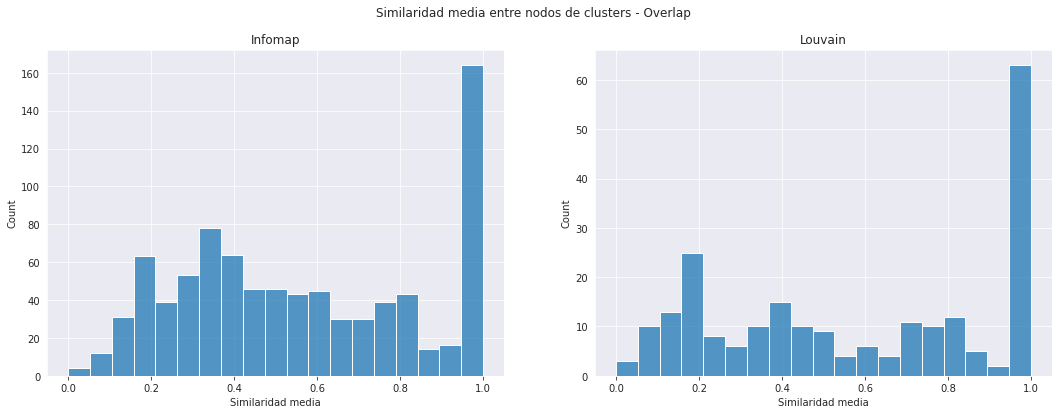

In [69]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Similaridad media entre nodos de clusters - Overlap")

sns.histplot(data=infomap_data_corregido["mean_sim_overlap_3"], ax=ax[0], bins=np.linspace(0,1,20))
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_data_corregido["mean_sim_overlap_3"], ax=ax[1],bins=np.linspace(0,1,20))
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

Text(0.5, 1.0, 'Louvain')

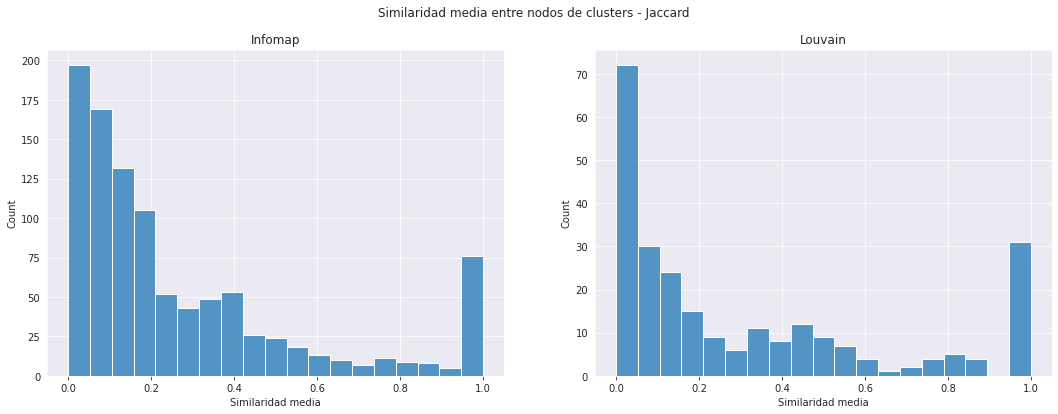

In [70]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Similaridad media entre nodos de clusters - Jaccard")

sns.histplot(data=infomap_all_metrics["mean_sim_jaccard_3"], ax=ax[0], bins=np.linspace(0,1,20))
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_all_metrics["mean_sim_jaccard_3"], ax=ax[1],bins=np.linspace(0,1,20))
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

# Supergrafico

In [21]:
infomap_data.columns

Index(['comunidad', 'tamaño', 'fraccion_gda', 'grado_gda_medio',
       'max_grado_gda', 'mean_sim_jaccard_1', 'mean_sim_overlap_1',
       'mean_sim_jaccard_3', 'mean_sim_overlap_3'],
      dtype='object')

In [91]:
case_dict = {1:"Genes",3:"Primeros vecinos"}

def supergrafico(df,metric,i,titulo):
    meansim_col = f"mean_sim_{metric}_{i}"
    frac_col = "fraccion_gda"
    size_col = "tamaño"
    fig = px.scatter(df, x=size_col, y=meansim_col,width=1000, height=600, title=f"Fracción GDA vs similaridad media vs tamaño - {titulo}",marginal_x="histogram",marginal_y="histogram",range_y=[0,1])
    fig.update_layout(xaxis_title="Tamaño", yaxis_title=f"Similaridad media - {case_dict[i]}")

    fig.show()

Ok, no depende ni del tamaño ni de la fracción de GDAs 

In [92]:
supergrafico(infomap_data_corregido,"overlap",3,"infomap")

# Veo clusters específicos

In [72]:
cols = ["comunidad","tamaño","mean_sim_lsa_0","entropia_0","top_monogram","top_5_monogram","top_monogram_score","top_5_monogram_score","top_trigram","top_bigram"]
infomap_summary = pd.read_pickle("../../../reports/reports_nohubs/infomap_summary.pkl")[cols]
louvain_summary = pd.read_pickle("../../../reports/reports_nohubs/louvain_summary.pkl")[cols]

In [50]:
infomap_summary[infomap_summary.top_5_monogram.apply(lambda x: "cancer" in x)]

,comunidad,tamaño,mean_sim_lsa_0,entropia_0,top_monogram,top_5_monogram,top_monogram_score,top_5_monogram_score,top_trigram,top_bigram
180,242,17,0.19,0.61,melanoma,"[melanoma, tumor, cancer, predisposition, heal]",0.29,"[0.29, 0.25, 0.23, 0.23, 0.23]",multiple_self_heal,self_heal
230,15,15,0.68,0.44,breast,"[breast, carcinoma, cancer, tumor, brca1]",0.79,"[0.79, 0.36, 0.19, 0.14, 0.14]",breast_ovarian_cancer,breast_carcinoma
242,5,15,0.77,0.35,prostate,"[prostate, carcinoma, cancer, familial, heredi...",0.89,"[0.89, 0.23, 0.22, 0.12, 0.11]",cancer_cause_mutation,prostate_cancer
381,104,11,0.24,0.50,vulva,"[vulva, vulvar, li, melanoma, cancer]",0.66,"[0.66, 0.54, 0.17, 0.17, 0.12]",unknown_etiology_affect,affect_vulva
429,28,10,0.50,0.46,bladder,"[bladder, carcinoma, squamous, urinary, cancer]",0.82,"[0.82, 0.36, 0.13, 0.11, 0.11]",squamous_cell_carcinoma,cell_carcinoma
503,628,9,0.78,0.44,colorectal,"[colorectal, cancer, nonpolyposis, carcinoma, ...",0.42,"[0.42, 0.4, 0.33, 0.31, 0.26]",hereditary_nonpolyposis_colon,hereditary_nonpolyposis
537,516,9,0.96,0.22,ovarian,"[ovarian, breast, cancer, susceptibility, fami...",0.59,"[0.59, 0.54, 0.39, 0.27, 0.21]",breast_ovarian_cancer,breast_ovarian
680,93,7,0.33,0.44,peritoneal,"[peritoneal, leiomyoma, cancer, smooth, benign]",0.47,"[0.47, 0.32, 0.27, 0.24, 0.24]",smooth_muscle_cell,cell_cancer
780,836,6,0.99,0.20,nonpolyposis,"[nonpolyposis, colorectal, hereditary, cancer,...",0.79,"[0.79, 0.33, 0.31, 0.29, 0.25]",cancer_hereditary_nonpolyposis,hereditary_nonpolyposis
798,627,5,0.98,0.13,colorectal,"[colorectal, cancer, susceptibility, pole, pap...",0.85,"[0.85, 0.41, 0.3, 0.1, 0.0]",cancer_cause_mutation,colorectal_cancer


In [51]:
ejemplo = 15
infomap_data[infomap_data.comunidad == ejemplo]

,comunidad,tamaño,fraccion_gda,grado_gda_medio,max_grado_gda,mean_sim_overlap_3,pvalue_overlap_3,pvalue,reject,rangos_fraccion
230,15,15,0.4,98.5,538.0,0.74,0.0,0.0,True,2


# Visualizaciones

In [45]:
def facet_range(x):
    if x <= 0.3:
        return 1
    elif x <= 0.6:
        return 2
    else:
        return 3

infomap_data["rangos_fraccion"] =  infomap_data.fraccion_gda.apply(lambda x: facet_range(x))

In [47]:
infomap_data

,comunidad,tamaño,fraccion_gda,grado_gda_medio,max_grado_gda,mean_sim_overlap_3,pvalue_overlap_3,pvalue,reject,rangos_fraccion
0,382,82,0.79,1.74,12.0,0.07,0.000,0.000000,True,3
1,184,74,0.99,1.75,24.0,0.12,0.000,0.000000,True,3
2,332,74,0.93,2.54,104.0,0.35,0.000,0.000000,True,3
3,353,71,0.75,3.26,37.0,0.34,0.000,0.000000,True,3
4,379,68,0.97,1.21,14.0,0.03,0.007,0.009107,True,3
...,...,...,...,...,...,...,...,...,...,...
1136,999,2,1.00,14.50,17.0,1.00,0.000,0.000000,True,3
1138,1000,2,1.00,4.00,4.0,1.00,0.000,0.000000,True,3
1139,1131,2,1.00,4.00,4.0,1.00,0.000,0.000000,True,3
1141,1136,2,1.00,2.50,4.0,1.00,0.000,0.000000,True,3


In [48]:
fig = px.histogram(infomap_data, x="mean_sim_overlap_3", facet_col="rangos_fraccion")
fig.show()

Sacar de la red DD los que no tienen GDA, hacer clustering de nuevo y ver estas cuentas

In [73]:
infomap_grafico = pd.merge(infomap_summary[["comunidad","tamaño","mean_sim_lsa_0","entropia_0"]], infomap_data[["comunidad","mean_sim_overlap_3"]], left_on="comunidad",right_on="comunidad")
infomap_grafico

,comunidad,tamaño,mean_sim_lsa_0,entropia_0,mean_sim_overlap_3
0,382,82,0.87,0.53,0.07
1,184,74,0.68,0.55,0.12
2,332,74,0.91,0.31,0.35
3,353,71,0.91,0.46,0.34
4,379,68,0.86,0.55,0.03
...,...,...,...,...,...
1002,1000,2,0.03,0.42,1.00
1003,1131,2,0.52,0.44,1.00
1004,1136,2,0.03,0.42,1.00
1005,891,2,0.33,0.49,0.15


In [85]:
def supergrafico_2(df,col_x,col_y,size,title):
    fig = px.scatter(df, x=col_x, y=col_y,width=1000, height=600,size=size, title=title,marginal_x="histogram",marginal_y="histogram",range_y=[0,1],range_x=[0,1])
    # fig.update_layout(xaxis_title="Fracción GDA", yaxis_title=f"Similaridad media - {case_dict[i]}")

    fig.show()

In [88]:
supergrafico_2(infomap_grafico,"mean_sim_overlap_3","mean_sim_lsa_0","tamaño","Infomap")